In [1]:
import pandas as pd
import numpy as np
import string 

df = pd.read_csv('training.1600000.processed.noemoticon.csv', sep=',', encoding='latin-1',  header=None)
df.columns = ["target","ids","date","flag","user","text"]
df = df.drop(["ids","date","flag","user"], axis = 1)
df.head()


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Zaawansowane przetwarzanie i czyszczenie danych (2 pkt)
- Wykorzystanie technik takich jak lematyzacja, stemming, uwzględnienie negacji.
- Obsługa emotikonów, skrótów, błędów ortograficznych.

In [2]:
import spacy
from nltk.tokenize.casual import EMOTICON_RE
import re

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

stop_words = pd.read_csv('stop_words.txt')
stop_words = stop_words.loc[:,'word'].tolist()
stopwords_simple = [word.replace("'", "") for word in stop_words]
stop_words = set(stop_words + stopwords_simple)

misspelled_words = pd.read_csv('misspelled_words.txt',sep='->')
misspelled_words = dict(zip(misspelled_words['miss'], misspelled_words['target']))

def replace_consecutive_chars(s):
    # Replace more than 3 consecutive '.' with exactly 3 of the same character
    s = re.sub(r'([\.])\1{2,}', r'\1\1\1', s)
    
    # Replace sequences of '!' and '?' with just one '!' or '?' respectively
    s = re.sub(r'[!?]+(?:\s*[!?]+)*', lambda m: m.group(0)[0], s)  # Replace with just the first character
    
    return s

def preprocess_text(text):
    # Filter out misspelled words
    text = replace_consecutive_chars(text)
    words = text.split()
    words = [misspelled_words[word.lower()] if word.lower() in misspelled_words else word for word in words]
    doc = nlp(' '.join(words))
    # Tokenize, lemmatize, and filter out punctuation, special characters, lowercase
    # Preserve emoticons
 
    # Feature engineering
    word_count = len([t for t in doc if not t.is_punct])
    avg_word_length = sum(len(t.text) for t in doc) / word_count if word_count else 0
    pos_counts = {pos: 0 for pos in ["NOUN", "VERB", "ADJ", "ADV", "PRON", "CCONJ", "ADP", "PROPN", "PUNCT"]}
    for token in doc:
        if token.pos_ in pos_counts:
            pos_counts[token.pos_] += 1

    words = [token.lemma_.lower() for token in doc if 
             (token.lemma_.isalpha() and token.lemma_.isascii() and not token.is_punct)
             or EMOTICON_RE.match(token.text) or token.text in ['!', '?', '...']]
    # Remove stopwords nicknames and links
    words = [word for word in words if word not in stop_words] 
    words = [word for word in words if not word.startswith(('@', 'http', 'https', 'www.'))]
    return {
        "tokens": words,
        **{f"freq_{pos.lower()}": pos_counts[pos] / word_count if word_count else 0 for pos in pos_counts},
        "avg_word_length": avg_word_length,
    }

C:\Users\Filip\AppData\Local\Temp\ipykernel_25400\4063546147.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  misspelled_words = pd.read_csv('misspelled_words.txt',sep='->')


In [3]:
import os.path
import swifter
fname = 'tokenized.gzip'
if os.path.isfile(fname):
    print("Loading saved file")
    df = pd.read_pickle('tokenized.gzip', compression='gzip')
else:
    print("Preprocessing text")
    features = pd.DataFrame(df['text'].swifter.apply(lambda x: preprocess_text(x)).tolist(), index=df.index)
    df.loc[df['target'] == 4, 'target'] = 1
    df = pd.concat([df,features],axis=1)
    df = df.drop(columns=['text'])
    # Save to file
    df.to_pickle('tokenized.gzip',
                compression='gzip') 
df.head()

Loading saved file


,target,tokens,freq_noun,freq_verb,freq_adj,freq_adv,freq_pron,freq_cconj,freq_adp,freq_propn,freq_punct,avg_word_length
0,0,"[awww, bummer, you, shoulda, get, david, carr,...",0.105263,0.105263,0.000000,0.000000,0.105263,0.000000,0.052632,0.315789,0.263158,5.052632
1,0,"[upset, he, can, not, update, his, facebook, t...",0.090909,0.136364,0.045455,0.045455,0.136364,0.045455,0.090909,0.090909,0.136364,4.090909
2,0,"[dive, many, time, ball, manage, save, rest, g...",0.277778,0.222222,0.055556,0.000000,0.055556,0.000000,0.166667,0.055556,0.055556,3.944444
3,0,"[my, whole, body, feel, itchy, and, like, its,...",0.200000,0.100000,0.200000,0.000000,0.200000,0.100000,0.200000,0.000000,0.000000,3.700000
4,0,"[no, not, behave, all, mad, why, here, ?, beca...",0.000000,0.125000,0.041667,0.250000,0.208333,0.000000,0.000000,0.000000,0.208333,3.750000


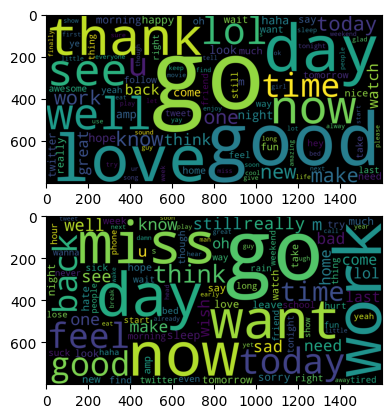

In [4]:
from wordcloud import WordCloud
from matplotlib.pyplot import subplots
positive_words = [word for words in df.loc[df['target'] == 1, 'tokens'].values.tolist() for word in words]
negative_words = [word for words in df.loc[df['target'] == 0, 'tokens'].values.tolist() for word in words]
pos_wc = WordCloud(max_words=100, width=1600, height=800, collocations=False).generate(' '.join(positive_words))
neg_wc = WordCloud(max_words=100, width=1600, height=800, collocations=False).generate(' '.join(negative_words))

fig, ax = subplots(nrows=2, ncols=1)
ax[0].imshow(pos_wc)
ax[1].imshow(neg_wc)

### Inżynieria cech i reprezentacja tekstu (1,5 pkt)
- Wykorzystanie embeddingu słów GloVe.
- Tworzenie dodatkowych cech: analiza części mowy, średnia długośc słów (podczas przetwarzania danych)

In [5]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3, random_state = 0)

Wektoryzacja 

In [6]:
import os

# Only the TensorFlow backend supports string inputs.
os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import numpy as np
import tensorflow.data as tf_data
import keras
from keras import layers
from keras.layers import Embedding

In [7]:
max_length = train_df['tokens'].apply(len).max().item()
print(max_length)
vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=max_length)
text_ds = tf_data.Dataset.from_tensor_slices(train_df['tokens'].apply(lambda x: ' '.join(x)).tolist()).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc,range(len(voc))))

39


In [8]:
# Glove embedding
# Download https://nlp.stanford.edu/data/glove.twitter.27B.zip 
# and extract glove.twitter.27B.100d.txt file
path_to_glove_file = "glove.twitter.27B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1193514 word vectors.


In [9]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
missed = []
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        missed.append(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19201 words (799 misses)


### Implementacja zaawansowanego modelu (2 pkt)
- Zastosowanie modeli takich jak sieci neuronowe (LSTM, CNN) lub transformatorów (BERT).
- Uzasadnienie wyboru modelu i opis architektury.

### Uzasadnienie architektury CNN

1. **Warstwa Embedding**: 
   - Służy do zamiany sekwencji indeksów słów na wektory osadzenia (embedding vectors), co pozwala na reprezentację semantyczną słów.
   - Wykorzystuje wstępnie wytrenowaną macierz osadzeń (`embedding_matrix`).

2. **Warstwy Conv1D**:
   - Wykrywają lokalne wzorce w sekwencjach (np. n-gramy).
   - Aktywacja `ReLU` wprowadza nieliniowość, umożliwiając modelowi naukę złożonych reprezentacji.

3. **MaxPooling1D**:
   - Redukuje rozmiar danych, zachowując najistotniejsze cechy, zapobiegając nadmiernemu dopasowaniu.

4. **GlobalMaxPooling1D**:
   - Wydobywa najważniejszą cechę z całej sekwencji, co jest przydatne w klasyfikacji tekstów.

5. **Warstwa Dense**:
   - Przekształca reprezentacje w bardziej złożone cechy.
   - `ReLU` wprowadza nieliniowość.

6. **Dropout**:
   - Zapobiega nadmiernemu dopasowaniu (overfitting), poprawiając generalizację modelu.

7. **Wyjście**:
   - Warstwa `sigmoid` służy do klasyfikacji binarnej, generując wynik w przedziale [0, 1].

8. **Kompilacja**:
   - Funkcja straty: `binary_crossentropy` (klasyfikacja binarna).
   - Optymalizator: `RMSprop`, często stosowany w zadaniach NLP.


### Optymalizacja i tuning hiperparametrów (1 pkt)
- Przeprowadzenie tuningu hiperparametrów Random Search.
- Uzasadnienie wyboru optymalnych parametrów.

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# preprocessing with standarization
def getX(df, train:bool):
    df2 = df.iloc[:,3:]
    vect_data = vectorizer(
        np.array(df["tokens"].apply(lambda x: [" ".join(x)]).tolist())
    ).numpy()
    if train:
        scaled_df2 = scaler.fit_transform(df2)
    else:
        scaled_df2 = scaler.transform(df2)
    feat_data = np.zeros(vect_data.shape)
    feat_data[:, : df2.shape[1]] = scaled_df2
    stacked = np.stack([vect_data, feat_data], axis=2)
    return stacked


x_train = getX(train_df, True)
x_test = getX(test_df, False)

y_train = train_df["target"].to_numpy()
y_test = test_df["target"].to_numpy()

In [11]:
import os
import keras
from keras import layers
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
import numpy as np
import tensorflow as tf

# Custom function to merge inputs
def prepare_inputs(x_embedding, x_features):
    return [np.array(x_embedding), np.array(x_features)]

from scikeras.wrappers import KerasClassifier
from keras.saving import register_keras_serializable

input_shape = (x_train.shape[1],x_train.shape[2])
additional_features_size = df.iloc[:,2:].shape[1]

@register_keras_serializable()
def extract_vector_input(x):
    return x[:,:,0]
@register_keras_serializable()
def extract_feature_input(x):
    return x[:,:additional_features_size,1]

# Definicja funkcji do stworzenia modelu
def create_model(filters, kernel_size, dense_units, dropout_rate,features_dense_units):
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        trainable=False,
    )
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # Combined input
    combi_input = layers.Input(input_shape) 
    vectors = layers.Lambda(extract_vector_input, name="lambda_1")(combi_input) 
    embedded_sequences = embedding_layer(vectors)
    x = layers.Conv1D(filters, kernel_size, activation="relu")(embedded_sequences)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(filters, kernel_size, activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(filters, kernel_size, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
        # Additional feature input
    additional_features_input = layers.Lambda(extract_feature_input, name="lambda_2")(combi_input)
    y = layers.Dense(features_dense_units, activation="relu")(additional_features_input)
    y = layers.Dense(1, activation="sigmoid")(y)

    # Combine embedding and additional features
    combined = layers.concatenate([x, y])
    z = layers.Dense(dense_units, activation="relu")(combined)
    z = layers.Dropout(dropout_rate)(z)
    preds = layers.Dense(1, activation="sigmoid")(z)

    model = Model(combi_input, preds)
    model.compile(
        loss="binary_crossentropy", optimizer='rmsprop', metrics=["acc"]
    )
    return model

In [12]:
# Logika wczytywania lub tworzenia nowego modelu
model_path = "cnn_model_optimized.keras"
if os.path.isfile(model_path):
    model = keras.models.load_model(model_path)
else:
    # Przygotowanie KerasClassifier do użycia z Random Search
    model = KerasClassifier(
        model=create_model,
        filters=64,
        kernel_size=3,
        dense_units=128,
        dropout_rate=0.5,
        verbose=0,
        batch_size=64,
        features_dense_units=16,
    )

    # Zakres hiperparametrów do przeszukania
    param_distributions = {
        "filters": [32, 64],
        "kernel_size": [2,3,4],
        "dense_units": [32, 64, 128, 256],
        "dropout_rate": [0.3, 0.5, 0.7],
        "batch_size": [32, 64],
        "epochs": [3],
        "features_dense_units":[32,64,128]
    }

    # Przeprowadzenie Random Search
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=15,
        n_jobs=1,
        cv=3,
        verbose=4,
        random_state=42,
    )

    # Dopasowanie modelu do danych
    search_result = search.fit(x_train, y_train)

    best_params = search_result.best_params_
    print("Najlepsze parametry:", best_params)
    print("Najlepszy wynik:", search_result.best_score_)
    print(f"Najlepsze parametry: {best_params}.")

    model = KerasClassifier(
        model=create_model,
        **best_params,
        verbose=1,
    )

    model.fit(x_train, y_train)
    model.model_.save(model_path)  # `model_.save` for scikeras wrapper
if getattr(model, "model_", None) is not None:
    model.model_.summary()
else:
    model.summary()

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_52      │ (None, 39, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 39)        │          0 │ input_layer_52[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_52        │ (None, 39, 100)   │  2,000,200 │ lambda_1[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_156 (Conv1D) │ (None, 36, 32)    │     12,832 │ embedding_52[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_104   │ (None, 18, 32)    │          0 │ conv1d_156[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_157 (Conv1D) │ (None, 15, 32)    │      4,128 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_105   │ (None, 7, 32)     │          0 │ conv1d_157[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 10)        │          0 │ input_layer_52[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_158 (Conv1D) │ (None, 4, 32)     │      4,128 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_208 (Dense)   │ (None, 128)       │      1,408 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_158[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_209 (Dense)   │ (None, 1)         │        129 │ dense_208[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_52      │ (None, 33)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ dense_209[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_210 (Dense)   │ (None, 256)       │      8,704 │ concatenate_52[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 256)       │          0 │ dense_210[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_211 (Dense)   │ (None, 1)         │        257 │ dropout_52[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,063,374 (7.87 MB)

 Trainable params: 31,586 (123.38 KB)

 Non-trainable params: 2,000,200 (7.63 MB)

 Optimizer params: 31,588 (123.39 KB)

### Porównanie z prostym modelem (0,5 pkt)
- Analiza różnic w wynikach między modelami.
- Wnioski dotyczące wpływu zaawansowanych technik.

Model CNN

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score
    
vectorizer
y_pred = model.predict(x_test)
roc_auc = roc_auc_score(y_test, y_pred)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
print("Dokładność modelu:", accuracy_score(y_test, y_pred))
print("Raport klasyfikacji:\n", classification_report(y_test, y_pred))
print(f"ROC_AUC {roc_auc}")

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 12s 818us/step
Dokładność modelu: 0.7976770833333333
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80    239877
           1       0.80      0.79      0.80    240123

    accuracy                           0.80    480000
   macro avg       0.80      0.80      0.80    480000
weighted avg       0.80      0.80      0.80    480000

ROC_AUC 0.8785251682067234


Prosty model regresji logistycznej

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=10000,
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

scaler = StandardScaler()
features_train = csr_matrix(scaler.fit_transform(train_df.iloc[:,3:]))
features_test = csr_matrix(scaler.transform(test_df.iloc[:,3:]))

X_train_linear = hstack([tfidf.fit_transform(train_df['tokens']), features_train])
X_test_linear = hstack([tfidf.transform(test_df['tokens']), features_test])
Y_train_linear = train_df['target']
Y_test_linear = test_df['target']

clf = LogisticRegression(random_state=0, max_iter = 10000, n_jobs=-1).fit(X_train_linear, Y_train_linear)
clf.score(X_train_linear, Y_train_linear)

0.8087080357142857

In [13]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
Y_train_linear = train_df['target']
Y_test_linear = test_df['target']

y_pred = clf.predict(X_test_linear)
print("Dokładność modelu:", accuracy_score(Y_test_linear, y_pred))
print("Raport klasyfikacji:\n", classification_report(Y_test_linear, y_pred))
roc_auc = roc_auc_score(Y_test_linear, clf.predict_proba(X_test_linear)[:, 1])
print(f"ROC_AUC {roc_auc}")

Dokładność modelu: 0.8053083333333333
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80    239877
           1       0.80      0.82      0.81    240123

    accuracy                           0.81    480000
   macro avg       0.81      0.81      0.81    480000
weighted avg       0.81      0.81      0.81    480000

ROC_AUC 0.8851786361956178


Etap 4 - porównanie z modelami LLM

Predykcja modelu CNN na wszystkich tweetach ze zbioru.

In [19]:
csv_data = pd.read_csv('training.1600000.processed.noemoticon.csv', sep=',', encoding='latin-1',  header=None)
csv_data.columns = ["target","ids","date","flag","user","text"]
csv_data['target'] = csv_data['target'].replace(4, 1)
csv_data.rename(columns={'target': 'target_tst'}, inplace=True)
csv_data = csv_data.drop(["ids","date","flag","user"], axis = 1)
csv_data.head()

df_combined = pd.concat([df, csv_data], axis=1)

OurModel = None
model_path = "cnn_model_optimized.keras"
if os.path.isfile(model_path):
    OurModel = keras.models.load_model(model_path)
    print("\033[92mModel Loaded\033[0m")
else:
    print(f"\033[91mModel not exist [{model_path}]\033[0m")

Model Loaded


In [20]:
def calculateTokenCoverage(df):
    def token_coverage(row):
        tokens = row['tokens']
        text = row['text'].lower()
        
        matching_tokens = sum(1 for token in tokens if token in text)
        if len(tokens) == 0:
            return 0
        return matching_tokens / len(tokens) * 100

    return df.apply(token_coverage, axis=1)

In [21]:
df_combined[['text','tokens']].head()
df_combined['token_coverage'] = calculateTokenCoverage(df_combined)
df_combined[['text', 'tokens', 'token_coverage']].sample(5)


,text,tokens,token_coverage
690244,i feel really bad coz i shouted at my mum on ...,"[feel, really, bad, coz, shout, my, mum, brigh...",100.000000
525466,Water on the laundry room floor; never a good ...,"[water, laundry, room, floor, never, good, sign]",100.000000
948081,Sick show. Headaches like gone!,"[sick, show, headache, like, go, !]",100.000000
1415108,@YvetteObeney here i am in beer garden after s...,"[here, beer, garden, after, several, shot]",100.000000
1244535,@goaudio I know. You have just said your in me...,"[know, you, have, just, say, your, meeting, we...",92.857143


In [22]:
X_all_tweet = getX(df, False)
Y_all_tweet = df["target"].to_numpy()


In [23]:
Y_all_tweet_pred = OurModel.predict(X_all_tweet)

50000/50000 ━━━━━━━━━━━━━━━━━━━━ 42s 836us/step


In [24]:
roc_auc = roc_auc_score(Y_all_tweet, Y_all_tweet_pred)
Y_all_tweet_pred[Y_all_tweet_pred >= 0.5] = 1
Y_all_tweet_pred[Y_all_tweet_pred < 0.5] = 0
print("Dokładność modelu:", accuracy_score(Y_all_tweet, Y_all_tweet_pred))
print("Raport klasyfikacji:\n", classification_report(Y_all_tweet, Y_all_tweet_pred))
print(f"ROC_AUC {roc_auc}")

Dokładność modelu: 0.800660625
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80    800000
           1       0.81      0.79      0.80    800000

    accuracy                           0.80   1600000
   macro avg       0.80      0.80      0.80   1600000
weighted avg       0.80      0.80      0.80   1600000

ROC_AUC 0.88187736410625


In [ ]:
df_combined['cnn_pred'] = Y_all_tweet_pred.flatten().astype(int)
difference_count = (df_combined['target'] != df_combined['target_tst']).sum()
print(f"Liczba rekordów, gdzie 'target' różni się od 'target_tst': {difference_count}")

df_to_save = df_combined[['target','text','tokens','cnn_pred']]
df_to_save.sample(10)

Liczba rekordów, gdzie 'target' różni się od 'target_tst': 0


,target,text,tokens,cnn_pred
1275805,1,@TheSims3 I cannot wait for the 5th in the uk ...,"[can, not, wait, uk, sim, release, here, !, so...",0
1445337,1,@mmitchelldaviss http://twitpic.com/64ppa - ab...,[absolutely],1
1428093,1,@eljefetwisted A couple of our TR people came ...,"[couple, our, tr, people, come, week, enjoy, v...",1
538974,0,"@Wan2SkiNow, my apologies if the house is not ...","[my, apology, if, house, not, clean, could, fi...",0
305016,0,@jenmurse That's how my last pair of chucks di...,"[my, last, pair, chuck, die, too, wear, til, e...",0
167656,0,@BlacksilkBlog Hugs to you for not being able ...,"[hug, you, not, able, shag, crush, anymore, x]",0
711636,0,@brettlarson I just wanted to say i LOVE your ...,"[just, want, say, love, your, online, show, an...",0
716120,0,I have a splinter im my toe I feel like im te...,"[have, splinter, m, my, toe, feel, like, m, te...",0
1345887,1,Off to see an optometrist so I can get a presc...,"[off, see, optometrist, so, can, get, prescrip...",0
1276544,1,yes..i am now a tweeter,"[yes, now, tweeter]",1


In [26]:
df_to_save['ID'] = range(1, len(df_to_save) + 1)

save_path = 'CNN_tweet_prediction.csv'
df_to_save.to_csv(
    save_path,
    sep=',',                # Separator przecinek
    index=False,            # Bez indeksów
    quoting=1,              # Cytowanie wszystkich wartości (1 odpowiada csv.QUOTE_ALL)
    quotechar='"',          # Użycie cudzysłowów
)

C:\Users\jakuw\AppData\Local\Temp\ipykernel_77776\3374487708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_save['ID'] = range(1, len(df_to_save) + 1)
